# Importing Required Libraries

In [1]:
#Importing required Libraries
import urllib
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import operator #For sorting dictionary

import sys
!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Creating a Resuable Parse function to scrape Indeed Jobs Website

In [2]:
#Creating a reusable parse function to Parse Indeed website
url_list=[]
urlbase = "https://www.indeed.com"
def parse(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    df = pd.DataFrame(columns=["Title","Location","Company","Salary","Summary"])
    #Loop to run on each job
    for each in soup.find_all(class_= "jobsearch-SerpJobCard" ):
        try:
            salary = each.find('div',{'class':'salarySnippet'}).text.replace('\n','')
        except:
            salary = 'None'
            continue
            #Continue the loop if the job doesn't have salary
        try: 
            title = each.find(class_='title').text.replace('\n', '')
        except:
            title = 'None'
        for loc in each.find_all(class_="sjcl" ):
            try:
                location_S = loc.find(class_='recJobLoc')
                location=location_S.attrs['data-rc-loc']
            except:
                location = 'None'
        try: 
            company = each.find(class_='company').text.replace('\n', '')
        except:
            company = 'None'
        #Loop to fetach summary information    
        for loc in each.find_all(class_="title" ):
            try:
                link = loc.find('a', {'class':'jobtitle turnstileLink '}).get('href')
                urlpost = urlbase+link 
                html_desc = requests.get(urlpost).text
                soup_desc = BeautifulSoup(html_desc, 'html.parser')
                for post in soup_desc.find_all(class_="jobsearch-jobDescriptionText"):
                    Summary=post.get_text().replace('\n','')
            except:
                Summary = None        
        df = df.append({'Title':title, 'Location':location, 'Company':company, 'Salary':salary,'Summary':Summary}, ignore_index=True,sort=True)
    return df

# Validating the Parse Function

In [3]:
#Checking if the function is working as expected
url="https://www.indeed.com/q-data-scientist-l-Bay-Area,-CA-jobs.html"
parse(url)

,Company,Location,Salary,Summary,Title
0,Sephora,"San Francisco, CA","$108,000 - $160,000 a year (In...",Job ID: 168216Location Name: CA-FSC SF Off (01...,"Intern, Data Scientist"
1,MasterClass,"San Francisco, CA","$106,000 - $156,000 a year (In...",Who we are:MasterClass is transforming online ...,Data Scientist
2,Blue Owl,"San Francisco, CA","$200,000 - $350,000 a year",A million people a year die in car collisions ...,Data Scientist - Insurance
3,Lennon Wright Associates,"San Francisco, CA","$120,000 - $220,000 a year",Our company has partnered up with a world-clas...,Data Scientist - ML/AI - San Francisco
4,Uber,"San Francisco, CA","$115,000 - $169,000 a year (In...",We’re changing the way people think about tran...,"Data Scientist - Machine Learning, Global Inte..."
5,LexisNexis,"San Francisco, CA","$118,000 - $174,000 a year (In...",At Ravel we develop the legal profession’s mos...,Data Scientist I
6,Visa,"Foster City, CA","$84,000 - $125,000 a year (Ind...",Job DescriptionTo ensure that Visa’s payment t...,Data Scientist
7,University of California San Francisco,"San Francisco, CA","$87,000 - $128,000 a year (Ind...",The Bioinformatics Programmer will work with t...,Data Scientist
8,Slack,"San Francisco, CA","$108,000 - $160,000 a year (In...",Slack is hiring experienced data scientists to...,"Data Scientist, Lifecyle"
9,Uber,"San Francisco, CA","$99,000 - $145,000 a year (Ind...","At Uber, we ignite opportunity by setting the ...",Data Scientist - Forecasting and Anomaly Detec...


#### Scraping the data to get atleast 400 Jobs with Salary and other required attributes

In [4]:
#Scraping the data
jobsdata = pd.DataFrame(columns=["Title","Location","Company","Salary","Summary"])
print('No of Jobs with Salary identified: ',len(jobsdata))
#Loop on Titles
for job in set (['data+scientist','data+analyst','business+analyst','data+engineer']):
    #Loop on Cities
    print('Running Loop to select a different Job title: ',job)
    for city in set (['New+York','Chicago','San+Francisco','San+Jose','Santa+Clara']):
        print('Running Loop to select a different City: ',city)
        for start in range(0,350,10):
            time.sleep(1) #To keep time gap between the requests
            print('Pausing for 1 second before triggering another request')
            #Condition to break out of loop if we had got 350 jobs
            if len(jobsdata)<=399:
                try:
                    #Calling the url
                    urls='https://www.indeed.com/jobs?q='+job+'&l={}&start={}'.format(city,start)
                    #Appending to the existing data frame
                    jobsdata=jobsdata.append(parse(urls),sort=True)
                    #To Drop duplicates
                    print('Removing duplicates from the data...')
                    jobsdata=jobsdata[jobsdata.Salary!='None'].drop_duplicates().dropna()
                    #Removing unwanted format of salary data
                    jobsdata = jobsdata[(~jobsdata.Salary.str.contains('an hour')) & (~jobsdata.Salary.str.contains('a month')) & (~jobsdata.Salary.str.contains('a week')) & (~jobsdata.Salary.str.contains('a day'))]
                    #To monitor the current number of jobs fetched
                    print('No of Jobs with Salary identified: ',len(jobsdata))
                except:
                    continue
            else:
                print('Scraping finished for 350 Jobs !!!')
                break

No of Jobs with Salary identified:  0
Running Loop to select a different Job title:  business+analyst
Running Loop to select a different City:  Chicago
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  3
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  3
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  3
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  4
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  6
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  6
Pausing for 1 second before triggering another request
Removing dupl

Removing duplicates from the data...
No of Jobs with Salary identified:  52
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  52
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  52
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  52
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  52
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  52
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  52
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  52
Pausing

Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  113
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  113
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  113
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  113
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  113
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  113
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  113
Pausing for 1 second before triggering another request
Removing duplicates f

Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  151
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  151
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  151
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  152
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  155
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  155
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  156
Pausing for 1 second before triggering another request
Removing duplicates f

Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  187
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  190
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  190
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  192
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  193
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  193
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  196
Pausing for 1 second before triggering another request
Removing duplicates f

Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  242
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  245
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  245
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  245
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  245
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  245
Running Loop to select a different City:  San+Jose
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  245
Pausing for 1 second befo

Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  280
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  280
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  282
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  282
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  282
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  282
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  282
Pausing for 1 second before triggering another request
Removing duplicates f

Removing duplicates from the data...
No of Jobs with Salary identified:  333
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  334
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  334
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  334
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  334
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  335
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  340
Pausing for 1 second before triggering another request
Removing duplicates from the data...
No of Jobs with Salary identified:  340

# Data Cleaning and Transformations

In [5]:
#Backing up the data frame in case of any issues while further cleaning the data
backupjobsdata=jobsdata

In [6]:
#Cleaning and extracting required columns from the data

In [7]:
jobsdata[['City','State']]=jobsdata['Location'].str.split(',',1,expand=True).rename(columns={0:'City',1:'State'})
#Dropping records with no salary
#Splitting Salary into Minimum and Maximum Salary
jobsdata = jobsdata[(~jobsdata.Salary.str.contains('an hour')) & (~jobsdata.Salary.str.contains('a month')) & (~jobsdata.Salary.str.contains('a week')) & (~jobsdata.Salary.str.contains('a day'))]
jobsdata[['Minimum Salary','Maximum Salary']]=jobsdata.Salary.str.replace('a year','').str.replace('\(Indeed est.\)','').str.replace(',', '').str.replace('$', '').str.split('-',1,expand=True).rename(columns={0:'Minimum Salary',1:'Maximum Salary'})
jobsdata

,Company,Location,Salary,Summary,Title,City,State,Minimum Salary,Maximum Salary
0,Focus Management Group USA Inc,"Chicago, IL","$60,000 - $75,000 a year",Job DescriptionAnalyst will interpret financia...,Business Financial Analyst,Chicago,IL,60000,75000
1,Trusymmetry Inc,"Chicago, IL","$50,000 - $60,000 a year",Junior Business AnalystRoles & Responsibilitie...,Junior Business Analyst,Chicago,IL,50000,60000
2,Excelsis Talent Recruiting Firm,"Chicago, IL","$120,000 - $180,000 a year","JOB SUMMARYLocations: Austin, Dallas, Atlanta,...",Sr. Business Analyst,Chicago,IL,120000,180000
2,United Airlines Inc.,"Chicago, IL","$84,000 - $125,000 a year (Ind...",We have a wide variety of career opportunities...,Senior Business Analyst,Chicago,IL,84000,125000
0,"Ryan Specialty Group, LLC","Chicago, IL","$72,000 - $108,000 a year (Ind...",Ryan Specialty Group is looking for an Busines...,Business Systems Analyst,Chicago,IL,72000,108000
1,Ryan Specialty Group,"Chicago, IL","$72,000 - $108,000 a year (Ind...",Ryan Specialty Group is looking for an Busines...,Business Systems Analyst,Chicago,IL,72000,108000
0,American Medical Association,"Chicago, IL","$64,000 - $95,000 a year (Inde...","Business Analyst IIChicago, ILThe American Med...",Business Analyst II (2),Chicago,IL,64000,95000
1,Newark element14,"Chicago, IL","$66,000 - $98,000 a year (Inde...","Nature and Purpose:The Sr. Specialist, Communi...","Sr. Specialist, Community Function...",Chicago,IL,66000,98000
2,The University of Chicago,"Chicago, IL","$63,000 - $93,000 a year (Inde...",Please make sure to read the job posting in it...,"Business Systems Analyst, Workday",Chicago,IL,63000,93000
0,"FTD Companies, Inc","Downers Grove, IL","$63,000 - $94,000 a year (Inde...",Job DescriptionWill add laterCompany Descripti...,"Senior, Business Analyst",Downers Grove,IL,63000,94000


# Clustering the data into groups to reduce number of data points.

In [7]:
#Clustering the data into groups using KMeans Clustering

In [9]:
#Preparing data for clustering by creating dummy columns on state to convert it into integer column for clustering
jobsdata_tr = pd.get_dummies(jobsdata, columns=['State'])

#Adding State back to the data frame
jobsdata_tr[['City','State']]=jobsdata_tr['Location'].str.split(',',1,expand=True).rename(columns={0:'CityNew',1:'State'})
jobsdata_tr['State']=jobsdata_tr['State'].astype(str)

#Selecting required columns for clustering
clmns = ['Minimum Salary','Maximum Salary','State_ CA', 'State_ IL','State_ NY']

#Converting string columns to integer columns
jobsdata_tr['Minimum Salary']=pd.to_numeric(jobsdata_tr['Minimum Salary'], errors='coerce')
jobsdata_tr['Maximum Salary']=pd.to_numeric(jobsdata_tr['Maximum Salary'], errors='coerce')


In [20]:
#Dropping NA Records from the dataset
jobsdata_tr=jobsdata_tr.dropna(how='any')

In [21]:
#Creating ZScores for the data set
jobsdata_tr_std = stats.zscore(jobsdata_tr[clmns],axis=0, ddof=0)

In [22]:
#Checking for NA on any of the columns
np.any(np.isnan(jobsdata_tr_std))

False

In [23]:
#Clustering the data into 5 Groups
#Cluster the data
kmeans = KMeans(n_clusters=5, random_state=0).fit(jobsdata_tr_std)
labels = kmeans.labels_

#Glue back to originaal data
jobsdata_tr['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

print(jobsdata_tr[clmns].groupby(['clusters']).mean())

          Minimum Salary  Maximum Salary  State_ CA  State_ IL  State_ NY
clusters                                                                 
0           84753.748031   122431.574803          1          0          0
1           77390.000000   112289.298701          0          1          0
2           62675.649123    80443.157895          0          0          1
3          104621.122449   150744.836735          0          0          1
4          119831.887324   176383.408451          1          0          0


# Scatter Plot for Clusters State Vs Salary

Text(29.9526,0.5,'Minimum Salary')

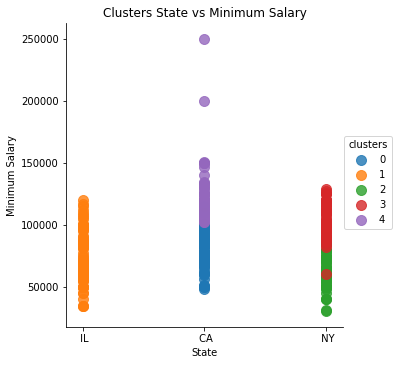

In [24]:
#Scatter plot of Wattage and Duration
sns.lmplot('State', 'Minimum Salary', 
           data=jobsdata_tr, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters State vs Minimum Salary')
plt.xlabel('State')
plt.ylabel('Minimum Salary')

Text(29.9526,0.5,'Maximum Salary')

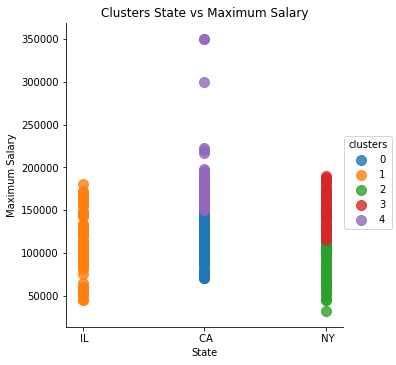

In [25]:
#Scatter plot of Wattage and Duration
sns.lmplot('State', 'Maximum Salary', 
           data=jobsdata_tr, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters State vs Maximum Salary')
plt.xlabel('State')
plt.ylabel('Maximum Salary')

# Dividing and storing the data of 5 clusters in 5 different Excel sheets

In [26]:
jobsdata_tr.to_excel('JobsCompleteData.xlsx', encoding='utf-8')
jobsdata_tr[jobsdata_tr.clusters==0].to_excel('JobsCluster1.xlsx', encoding='utf-8')
jobsdata_tr[jobsdata_tr.clusters==1].to_excel('JobsCluster2.xlsx', encoding='utf-8')
jobsdata_tr[jobsdata_tr.clusters==2].to_excel('JobsCluster3.xlsx', encoding='utf-8')
jobsdata_tr[jobsdata_tr.clusters==3].to_excel('JobsCluster4.xlsx', encoding='utf-8')
jobsdata_tr[jobsdata_tr.clusters==4].to_excel('JobsCluster5.xlsx', encoding='utf-8')

# Top 15 Companies who are recruiting

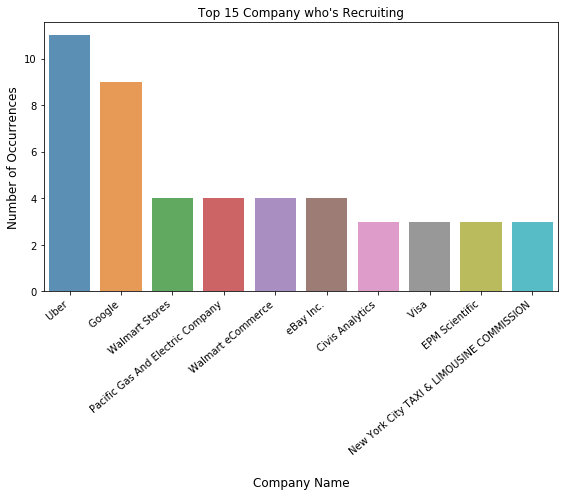

In [27]:
count = jobsdata_tr['Company'].value_counts()
#here is where you determine Stop point. for small data set you have to stop at maybe 5 or 6
company_count = count[:10]

plt.figure(figsize=(8,7))
#this will plot the data in seaborn
ax = sns.barplot(company_count.index, company_count.values, alpha=0.8)
#we have to include this line of code to avoid over laping since some company name are very long
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#here is the labels 
plt.title("Top 15 Company who's Recruiting")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Company Name', fontsize=12)
plt.tight_layout()
plt.show()

# Text Map of different Job titles

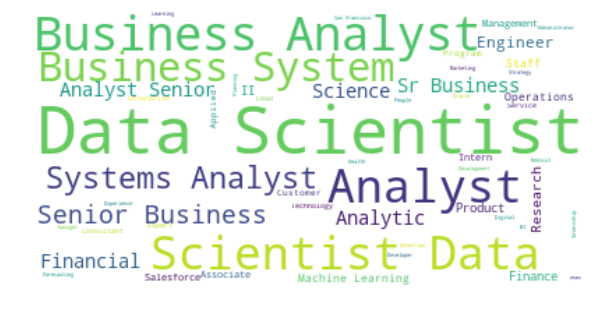

In [28]:


#Text Map Script for Titles
text = " ".join(review for review in jobsdata_tr.Title)
#wordcloud = WordCloud().generate(loc)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
wordcloud.to_file("TextMining-Titles.png")
plt.show()

# Summarizing Top 5 Hot skills mentioned in different Job Descriptions

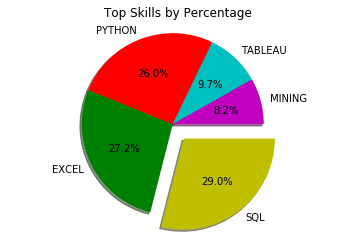

In [29]:
#Using Regex to summarize hot skills from summary
jobdesc = jobsdata_tr['Summary']
counts = dict()

regex = 'mining|hadoop|Python|Java|SQL|Tableau|Excel|sas|spotfire|ipython|matlab|splunk|qlikview|qliksense' 
#regex = 'sas|hadoop|tableau|qlikview|excel|spark|spotfire|ipython|matlab|splunk'
pattern = re.compile(regex) #Compile a regular expression pattern into a regular expression object

for words in jobdesc:
    title = re.findall(pattern, words) # in the file htmltext, find all that fits the pattern
    title = list(set(title))
    for i in title:
        counts[i] = counts.get(i, 0) + 1

#Getting Top 5 Skills
top5counts = dict(sorted(counts.items(), key=operator.itemgetter(1), reverse=True)[:5])

#Vizualizing the Skills data:
Skillcounts = top5counts.values()
skills = {k.upper(): v for k, v in top5counts.items()}
colors = ['y', 'g', 'r', 'c', 'm']
explode = (0.2, 0, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(Skillcounts, labels=skills,colors=colors,explode=explode,autopct='%1.1f%%',counterclock=False, shadow=True)  
plt.title('Top Skills by Percentage')
ax1.axis('equal')
plt.show()

# Top 15 Cities by highest number of Jobs

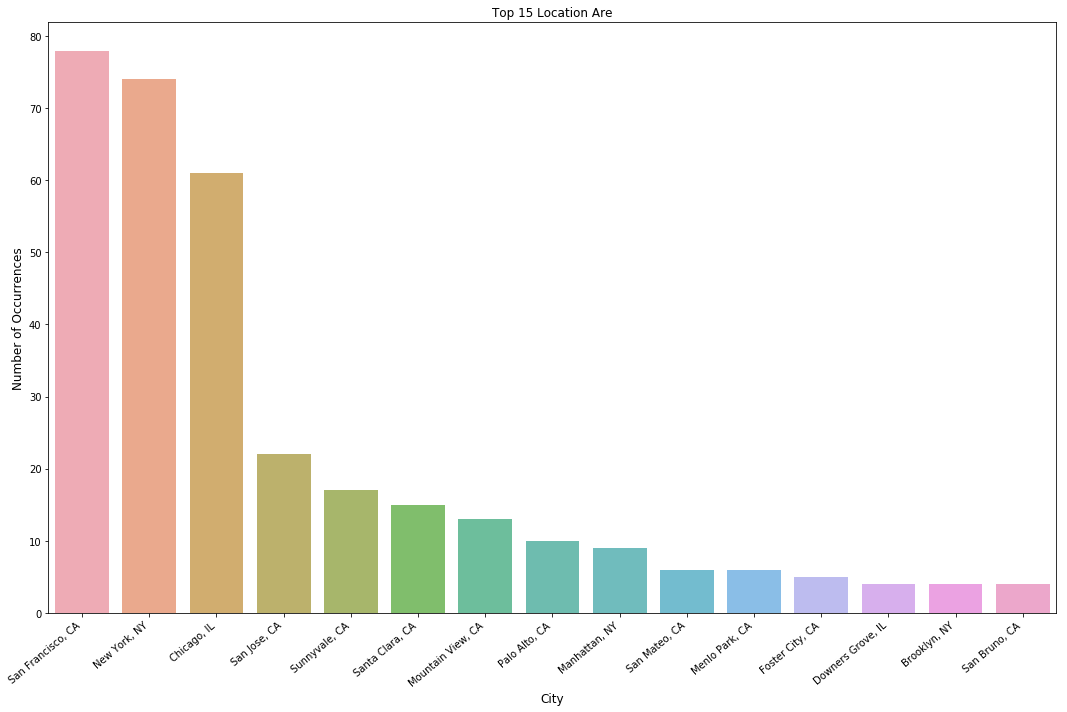

In [30]:
#here is where you determine Stop point. for small data set you have to stop at maybe 5 or 6
location_count  = jobsdata_tr['Location'].value_counts()

location_count = location_count[:15]

plt.figure(figsize=(15,10))
#this will plot the data in seaborn
ax = sns.barplot(location_count.index, location_count.values, alpha=0.8)
#we have to include this line of code to avoid over laping since some company name are very long
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#here is the labels 
plt.title("Top 15 Location Are")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.tight_layout()
plt.show()
